# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**1.1. Импортируем библиотеки.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

**1.1.2. Считаем данные из csv-файла в датафрейм и сохраним в переменные.**

In [2]:
# прочитаем csv-файл
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

**1.1.3. Изучим общую информацию о полученном датафрейме.**

In [3]:
df.head(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
# Вывод основной информации о датафрейме с помощью метода info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# заполним пустые значения наиболее часто встречающимися значениями в столбце
df["VehicleType"] = df["VehicleType"].fillna(df["VehicleType"].mode()[0])
df["Gearbox"] = df["Gearbox"].fillna(df["Gearbox"].mode()[0])
df["FuelType"] = df["FuelType"].fillna(df["FuelType"].mode()[0])
df["Repaired"] = df["Repaired"].fillna(df["Repaired"].mode()[0])

<div class="alert alert-block alert-success">
<b>Успех:</b> Пропуски обработаны хорошим образом, но я бы предпочел новое значение
</div>

In [6]:
# заменим значение 0 на медианное значение месяца
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = df['RegistrationMonth'].median()
df["RegistrationMonth"].unique()

array([ 6.,  5.,  8.,  7., 10., 12., 11.,  2.,  3.,  1.,  4.,  9.])

**1.4. Выполним проверку на дубликаты.**

In [7]:
# Выполним пороверку на дубликаты
df.duplicated().sum()

5

In [8]:
# Удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

**1.5 Построим общую гистограмму для колличественных столбцов таблицы.**

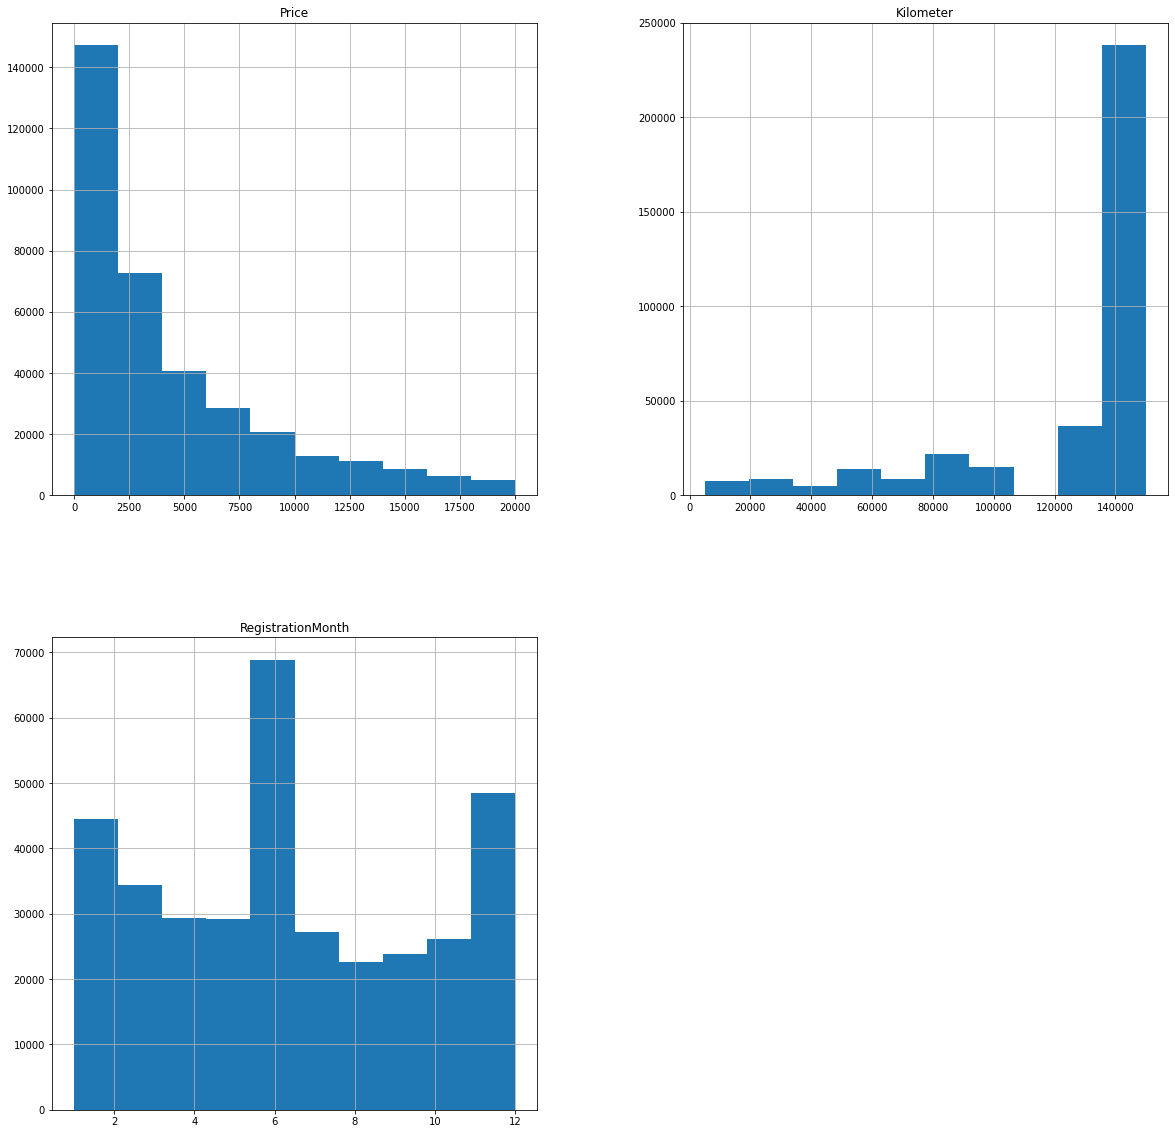

In [9]:
df_qty = df[['Price', 'Kilometer', 'RegistrationMonth']]
df_qty.hist(figsize=(20, 20))
plt.show()

1.5.1 Построим диаграммы для категориальных столбцов датафрейма.

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


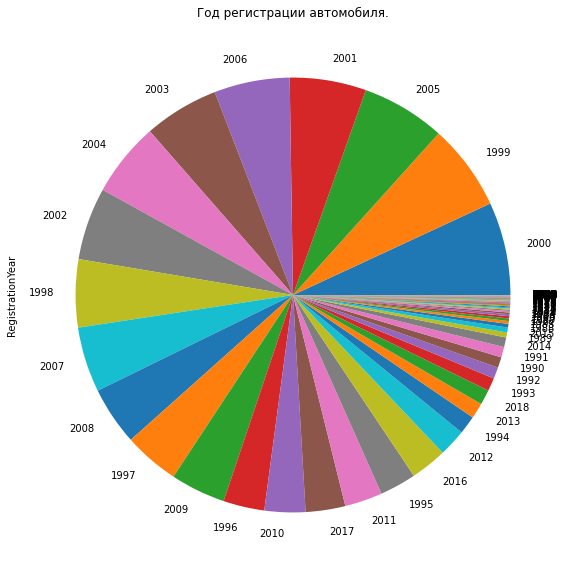

In [10]:
df['RegistrationYear'].value_counts(normalize=True).plot(kind='pie', subplots = True, figsize=(10, 10))
plt.title('Год регистрации автомобиля.')
plt.show()

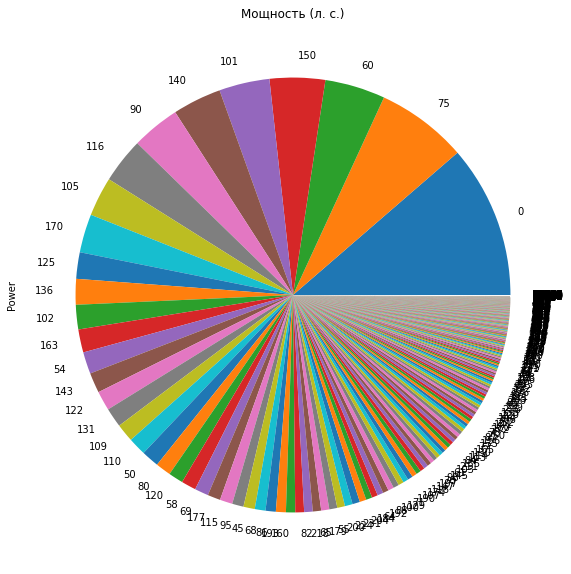

In [11]:
df['Power'].value_counts(normalize=True).plot(kind='pie', subplots = True, figsize=(10, 10))
plt.title('Мощность (л. с.)')
plt.show()

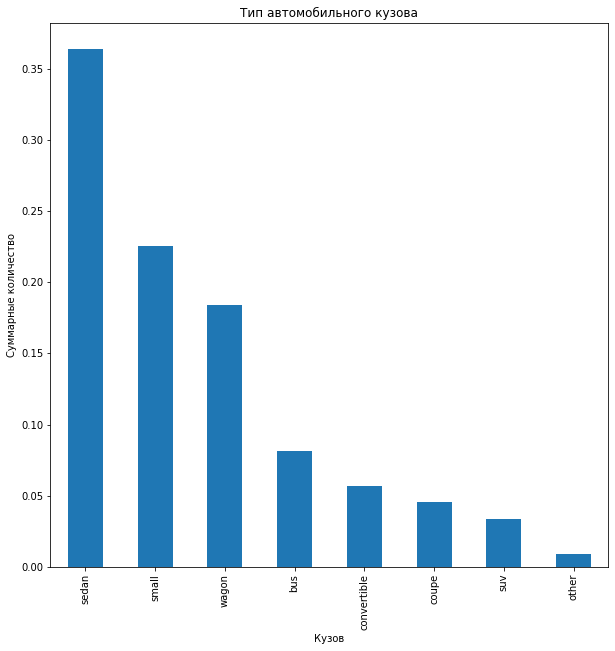

In [12]:
df['VehicleType'].value_counts(normalize=True).plot(kind='bar', subplots = True, figsize=(10, 10))
plt.title('Тип автомобильного кузова')
plt.xlabel('Кузов')
plt.ylabel('Суммарные количество')
plt.show()

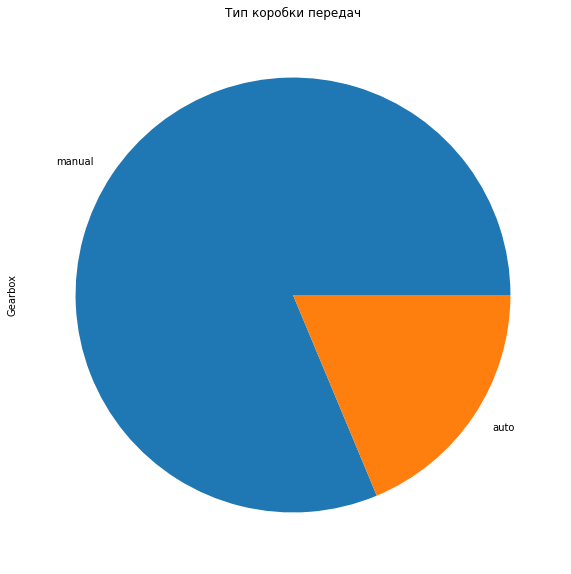

In [13]:
df['Gearbox'].value_counts(normalize=True).plot(kind='pie', subplots = True, figsize=(10, 10))
plt.title('Тип коробки передач')
plt.show()

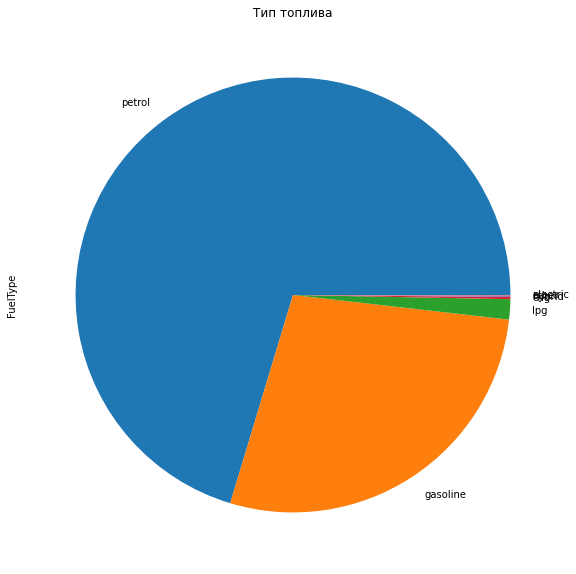

In [14]:
df['FuelType'].value_counts(normalize=True).plot(kind='pie', subplots = True, figsize=(10, 10))
plt.title('Тип топлива')
plt.show()

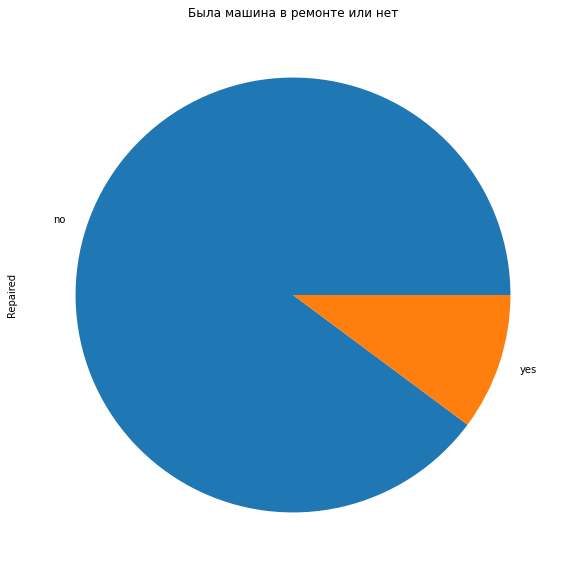

In [15]:
df['Repaired'].value_counts(normalize=True).plot(kind='pie', subplots = True, figsize=(10, 10))
plt.title('Была машина в ремонте или нет')
plt.show()

**1.6 Найдем пропущенные значения в столбцах**

In [16]:
# определим в каких столбцах есть пропуски метом isna() и sum()
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired                 0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [17]:
#произведем замену пустых значений в столбце Модель на 'Unknown'
df['Model'] = df['Model'].fillna('Unknown')
df.isna().sum() 

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

**1.7 Проверим аномальные значения в столбцах.** 

In [18]:
# найдем цены с аномальным значением 
df['Price'].describe()

count    354364.000000
mean       4416.655608
std        4514.159690
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

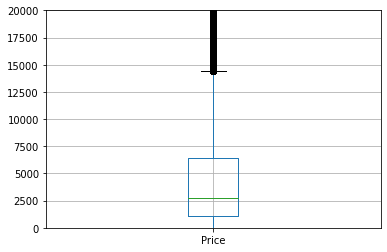

In [19]:
df.boxplot(column='Price')
plt.ylim(0, 20000)
plt.show()

На диаграмме boxplot в размах «усов» попадают нормальные значения, а за пределами находятся выбросы. Отбросим значение больше 1,5 межквартильного размаха.


In [20]:
# удалим значения с ценой менее 200 евро
df = df.loc[(df['Price'] > 200)]

In [21]:
# найдем мощность дивгтаеля с аномальным значением 
df['Power'].describe()

count    334916.000000
mean        112.413107
std         187.205208
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

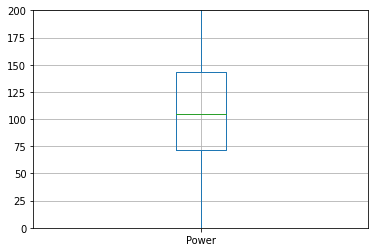

In [22]:
df.boxplot(column='Power')
plt.ylim(0, 200)
plt.show()

In [23]:
# Удалим выбивающиеся значения для мощности двителея менее 13л лс и более 600 лс.
df = df.loc[df['Power'] < 510]

In [24]:
# найдем года выпуска автомобилей с аномальным значением 
df['RegistrationYear'].describe()

count    334521.000000
mean       2003.986659
std          67.387643
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

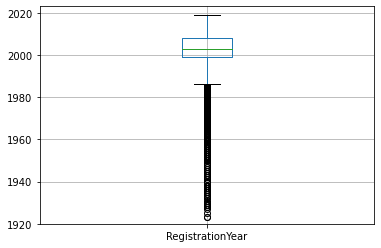

In [25]:
df.boxplot(column='RegistrationYear')
plt.ylim(1920, 2023)
plt.show()

In [26]:
# Удалим выбивающиеся значения для года выпуска автомобиля раньше 1940 г и позже 2016 года.
df = df.loc[(df['RegistrationYear'] > 1920)&(df['RegistrationYear'] < 2016)] 

In [27]:
df['NumberOfPictures'].unique() # поиск неявных дубликатов методом unique() 

array([0])

Выполним удаление столбцов которые не будут участвовать в обучении и не окажут влияние на определение стоимости автомобиля.

In [28]:
df = df.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode",'RegistrationYear'],axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312603 entries, 0 to 354363
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              312603 non-null  int64  
 1   VehicleType        312603 non-null  object 
 2   Gearbox            312603 non-null  object 
 3   Power              312603 non-null  int64  
 4   Model              312603 non-null  object 
 5   Kilometer          312603 non-null  int64  
 6   RegistrationMonth  312603 non-null  float64
 7   FuelType           312603 non-null  object 
 8   Brand              312603 non-null  object 
 9   Repaired           312603 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 26.2+ MB


**Вывод по текущему разделу.**
1. Произвел заполнение пустых значений наиболее часто встречающимися значениями в столбцах к категориальными значениями. Объем пустых значений около 20% от датасета. Удаление пустых значений считаю не допустимо.
2. Проведена проверка на дубликаты. Найдено 5 дубликатов, дубликаты удалены.
3. Выполнено построение диаграмм, столбчатых и круговых графиков.
4. Произведена замена пустых значений в столбце Модель на 'Unknown', т.к. заполнить пустые ячейки наиболее часто встречающемся значением модели не будет корректным.
5. Выполнена проверка и удаление аномальных значений в столбцах:
- цена автомобиля (Price): удалены значения с ценой менее 200 евро (по данным сайта auto.ru) 
- мощность двигателя (Power): удалены значения для мощности двигателя более 510 лс (по данным сайта auto.ru) 
- год выпуска автомобиля (RegistrationYear): удалены значения раньше 1920 г  и позже 2016 года (по данным сайта auto.ru)
6. Выполнено удаление столбцов которые не будут участвовать в обучении и не окажут влияние на определение стоимости автомобиля, либо полностью пустых столбцов.

## Обучение моделей

**2.1. Модель линейной регрессии.**

In [31]:
# выполним копирование датафрейма для модели градиентного бустинга LightGBM
df_for_lightgbm = df.copy()

In [32]:
#переведем категориальные значения столбцов в количественные для модели Линейной регрессии 
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,Price,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
0,480,0,150000,6.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,190,125000,5.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,163,125000,8.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1500,75,150000,6.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,69,90000,7.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [33]:
# признак и целевой признак для модели Линейной регрессии
features_ohe = df_ohe.drop('Price', axis=1)
target_ohe = df_ohe['Price']

2.2.1 Произведём двухэтапое деление. Первый этап - деление на двухкомпонентную выборку: обучающая (60%) и валидационная + тестовая (40%). Второй этап - деление на двухкомпонентную выборку уже разделенной валидационной + тестовой выборки: валидационная (80%) и тестовая (20%). Итого получилось 3 выборки: обучающая (60%), валидационная (20%) и тестовая (20%).

In [34]:
# обучающая и валидационная + тестовая выборки, 60% и 40%
features_train_ohe, features_val_test_ohe, target_train_ohe, target_val_test_ohe = train_test_split(features_ohe, 
                                                                                  target_ohe,
                                                                                  train_size=0.6, 
                                                                                  random_state=12345) 
                                                                                                  
# валидационная и тестовая выборки, 20% и 20%
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(features_val_test_ohe,
                                                                            target_val_test_ohe, 
                                                                            test_size=0.2, 
                                                                            random_state=12345)

In [35]:
# проверка пропорций полученных выборок.
features_train_ohe.shape, target_train_ohe.shape, features_valid_ohe.shape, target_valid_ohe.shape, features_test_ohe.shape, target_test_ohe.shape

((187561, 307), (187561,), (100033, 307), (100033,), (25009, 307), (25009,))

In [36]:
%%time
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(features_train_ohe, target_train_ohe)

CPU times: user 12.4 s, sys: 9.09 s, total: 21.5 s
Wall time: 21.4 s


LinearRegression()

In [37]:
%%time
predictions_valid = model_LinearRegression.predict(features_valid_ohe)
mse = mean_squared_error(target_valid_ohe, predictions_valid)
# значение метрики RMSE на валидационной выборке
print("RMSE для LinearRegression: ", mse ** 0.5) 

RMSE для LinearRegression:  2969.0577680990964
CPU times: user 124 ms, sys: 114 ms, total: 238 ms
Wall time: 206 ms


**2.2 Модель случайный лес.**

In [38]:
# выполним порядковое кодирование классом OrdinalEncoder
df_oe = OrdinalEncoder()
df_oe.fit(df[['VehicleType','RegistrationMonth', 'Gearbox', 'Power', 
            'Model','Kilometer','FuelType','Brand', 'Repaired']])
df[['VehicleType','RegistrationMonth', 'Gearbox', 'Power', 
            'Model', 'Kilometer','FuelType', 'Brand', 'Repaired']] = df_oe.transform(df[['VehicleType','RegistrationMonth', 'Gearbox', 'Power', 
            'Model', 'Kilometer','FuelType', 'Brand', 'Repaired']])

In [39]:
# признак и целевой признак для модели Случайный лес
features_oe = df.drop('Price', axis=1)
target_oe = df['Price']

In [40]:
# выборки для модели Случайный лес
# обучающая и валидационная + тестовая выборки, 60% и 40%
features_train_oe, features_val_test_oe, target_train_oe, target_val_test_oe = train_test_split(features_oe, 
                                                                          target_oe,
                                                                          train_size=0.6, 
                                                                          random_state=12345) 
                                                                          
# валидационная и тестовая выборки, 20% и 20%
features_valid_oe, features_test_oe, target_valid_oe, target_test_oe = train_test_split(features_val_test_oe,
                                                                            target_val_test_oe, 
                                                                            test_size=0.2, 
                                                                            random_state=12345)
                                                                            

In [41]:
# проверка пропорций полученных выборок
features_train_oe.shape, target_train_oe.shape, features_valid_oe.shape, target_valid_oe.shape, features_test_oe.shape, target_test_oe.shape

((187561, 9), (187561,), (100033, 9), (100033,), (25009, 9), (25009,))

In [42]:
%%time
best_result = 3000
best_est = 0
best_depth = 0
for est in [5, 20, 50]:
    for depth in [5, 10, 20]:
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train_oe, target_train_oe)
        predictions_train_oe = model.predict(features_valid_oe)
        rmse = mean_squared_error(target_valid_oe, predictions_train_oe)**0.5
        print('Количество деревьев:', est, 'Глубина:', depth)
        print("RMSE для RandomForest:", rmse)
        if rmse < best_result:
            best_result = rmse #  сохраните наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            best_depth = depth
print()
print("RMSE для RandomForest:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Количество деревьев: 5 Глубина: 5
RMSE для RandomForest: 2985.1648824235085
Количество деревьев: 5 Глубина: 10
RMSE для RandomForest: 2553.027658089439
Количество деревьев: 5 Глубина: 20
RMSE для RandomForest: 2327.2841094775877
Количество деревьев: 20 Глубина: 5
RMSE для RandomForest: 2980.4199179128123
Количество деревьев: 20 Глубина: 10
RMSE для RandomForest: 2534.2187367436773
Количество деревьев: 20 Глубина: 20
RMSE для RandomForest: 2231.507239153919
Количество деревьев: 50 Глубина: 5
RMSE для RandomForest: 2978.5339105195717
Количество деревьев: 50 Глубина: 10
RMSE для RandomForest: 2530.1399540698476
Количество деревьев: 50 Глубина: 20
RMSE для RandomForest: 2212.1243361552188

RMSE для RandomForest: 2212.1243361552188 Количество деревьев: 50 Максимальная глубина: 20
CPU times: user 1min 4s, sys: 60.7 ms, total: 1min 4s
Wall time: 1min 5s


In [43]:
%%time
model_RandomForest = RandomForestRegressor(criterion='friedman_mse', random_state=12345, n_estimators=50, max_depth=20) # инициализировать модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
model_RandomForest.fit(features_train_oe, target_train_oe) # обучить модель на тренировочной выборке

CPU times: user 20.3 s, sys: 246 ms, total: 20.6 s
Wall time: 20.6 s


RandomForestRegressor(criterion='friedman_mse', max_depth=20, n_estimators=50,
                      random_state=12345)

In [44]:
%%time
predictions_valid = model_RandomForest.predict(features_valid_oe) # получить предсказания модели на валидационной выборке
print("RMSE для RandomForest:", mean_squared_error(target_valid_oe, predictions_valid)**0.5)

RMSE для RandomForest: 2212.068811326969
CPU times: user 1.42 s, sys: 9.71 ms, total: 1.43 s
Wall time: 1.44 s


**2.3 Модель градиентного бустинга LightGBM.**

In [45]:
features = df_for_lightgbm.drop('Price', axis=1)
target = df_for_lightgbm['Price']

In [46]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312603 entries, 0 to 354363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        312603 non-null  object 
 1   Gearbox            312603 non-null  object 
 2   Power              312603 non-null  int64  
 3   Model              312603 non-null  object 
 4   Kilometer          312603 non-null  int64  
 5   RegistrationMonth  312603 non-null  float64
 6   FuelType           312603 non-null  object 
 7   Brand              312603 non-null  object 
 8   Repaired           312603 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 23.8+ MB


In [47]:
# изменим тип признаков на category для категорийных данных
for i in features.columns:
    type_columns = features[i].dtype
    if type_columns == 'object':
        features[i] = features[i].astype('category')

In [48]:
# выборки для модели градиентного бустинга LightGBM
# обучающая и валидационная + тестовая выборки, 60% и 40%
features_train, features_val_test, target_train, target_val_test = train_test_split(features, 
                                                                          target,
                                                                          train_size=0.6, 
                                                                          random_state=12345) 
                                                                          
# валидационная и тестовая выборки, 20% и 20%
features_valid, features_test, target_valid, target_test = train_test_split(features_val_test,
                                                                            target_val_test, 
                                                                            test_size=0.2, 
                                                                            random_state=12345)

In [49]:
# проверка пропорций полученных выборок
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((187561, 9), (187561,), (100033, 9), (100033,), (25009, 9), (25009,))

In [50]:
%%time
# модель LGBMRegressor с паметрами: boosting = 'gbdt', max_depth=50 — максимальная глубина для деревьев в ансамбле,
# n_estimators=50 -  количество деревьев, learning_rate=1 - скорость обучения,
# metric="mse"- метрики для расчета на оценочных наборах данных
model_LightGBM = LGBMRegressor(boosting_type ='gbdt', metric= "rmse", max_depth=50, n_estimators=50, learning_rate=1)
model_LightGBM.fit(features_train, target_train)

CPU times: user 3min 12s, sys: 2.19 s, total: 3min 14s
Wall time: 3min 15s


LGBMRegressor(learning_rate=1, max_depth=50, metric='rmse', n_estimators=50)

In [51]:
%%time
predicted = model_LightGBM.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE для LGBMRegressor:", mse**0.5)

RMSE для LGBMRegressor: 2303.201663263887
CPU times: user 434 ms, sys: 0 ns, total: 434 ms
Wall time: 422 ms


**Вывод по текущему разделу.**
1. Разделил данные на признаки и целевой признак. Преобразовал  категориальные признаки в численные техникой прямого кодирования OHE для Линейной регрессии. Выполнил порядковое кодирование классом OrdinalEncoder для моделей RandomForestRegressor и LightGBM. 
2.  Произвел деление данных на обучающие, валидационные и тестовые.
3.  Обучил модели  LinearRegression, RandomForestRegressor, LGBMRegressor. Проанализировал время обучения, время предсказания и качество моделей.
4. Лучший результат показала модель RandomForestRegressor.

## Анализ моделей

**3.1 Получим значения RMSE на тестовой выборке для модели RandomForestRegressor** 

In [52]:
%%time
predictions_valid = model_RandomForest.predict(features_test_oe) # получить предсказания модели на валидационной выборке
print("RMSE для RandomForest:", mean_squared_error(target_test_oe, predictions_valid)**0.5)

RMSE для RandomForest: 2209.7177404426893
CPU times: user 411 ms, sys: 0 ns, total: 411 ms
Wall time: 447 ms


In [53]:
importances = model_RandomForest.feature_importances_  
feature_list = list(features_train_oe.columns) 
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances}) 
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)  
feature_results.head(10) 

,feature,importance
0,Power,0.419176
1,Kilometer,0.246341
2,Model,0.078262
3,FuelType,0.072403
4,Brand,0.062503
5,RegistrationMonth,0.049764
6,VehicleType,0.042290
7,Repaired,0.018131
8,Gearbox,0.011130


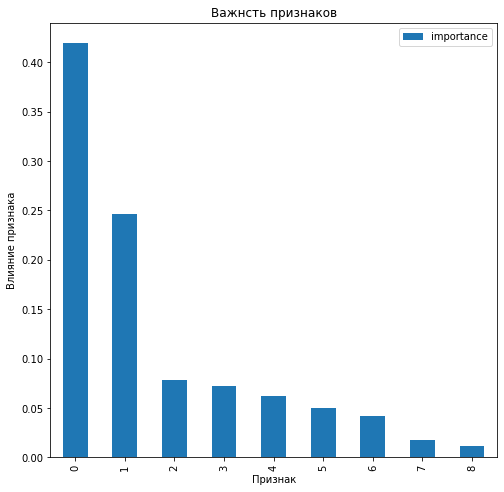

In [54]:
feature_results.plot(kind='bar',figsize=(8, 8))
plt.title('Важнсть признаков')
plt.xlabel('Признак')
plt.ylabel('Влияние признака')
plt.show()

**Время обучение моделей:**
- LinearRegression 33 s
- **RandomForestRegressor 20.2 s**
- LGBMRegressor 3min 17s

**Время предсказаний моделей:**
- **LinearRegression 213 ms**
- RandomForestRegressor 1.46 s
- LGBMRegressor 414 ms

**Качество моделей:**
- LinearRegression 2969
- **RandomForestRegressor 2212**
- LGBMRegressor 2303

Самое высокая скорость обучения у модели RandomForestRegressor.
Самое высокая скорость предсказания у модели LinearRegression.
Лучшее качество модели у RandomForestRegressor.
При проверке на тестовой выборке значение метрики RMSE 2209.
Согласно критерию заказчика значение метрики RMSE должно быть меньше 2500.
Качество модели соответствующее данному критерию.

Модель RandomForestRegressor можно порекомендовать по параметрам качество/скорость.